<a href="https://colab.research.google.com/github/Mckngbird/portfolio-ds/blob/main/Modelo_Predictivo_SHAP%26LIME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Compatibilizar version de SHAMP para colab


In [ ]:
!pip install shap==0.41.0


In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=6cafc8c4bd6f769017772081c056ddb3fa7bdadb8a5fbae5a0faae81f736da25
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


Importaciones

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import shap
import lime
import lime.lime_tabular

Subir archivo

In [ ]:
# Descargar el dataset directamente desde Kaggle
path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")
print("Dataset descargado en:", path)

# Cargar dataset
df = pd.read_csv(path + "/heart.csv")

# Vista dataset
print("Dimensiones:", df.shape)
print("Valores nulos por columna:\n", df.isnull().sum())
df.head()

Using Colab cache for faster access to the 'heart-failure-prediction' dataset.
Dataset descargado en: /kaggle/input/heart-failure-prediction
Dimensiones: (918, 12)
Valores nulos por columna:
 Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0

Limpieza y análisis

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object


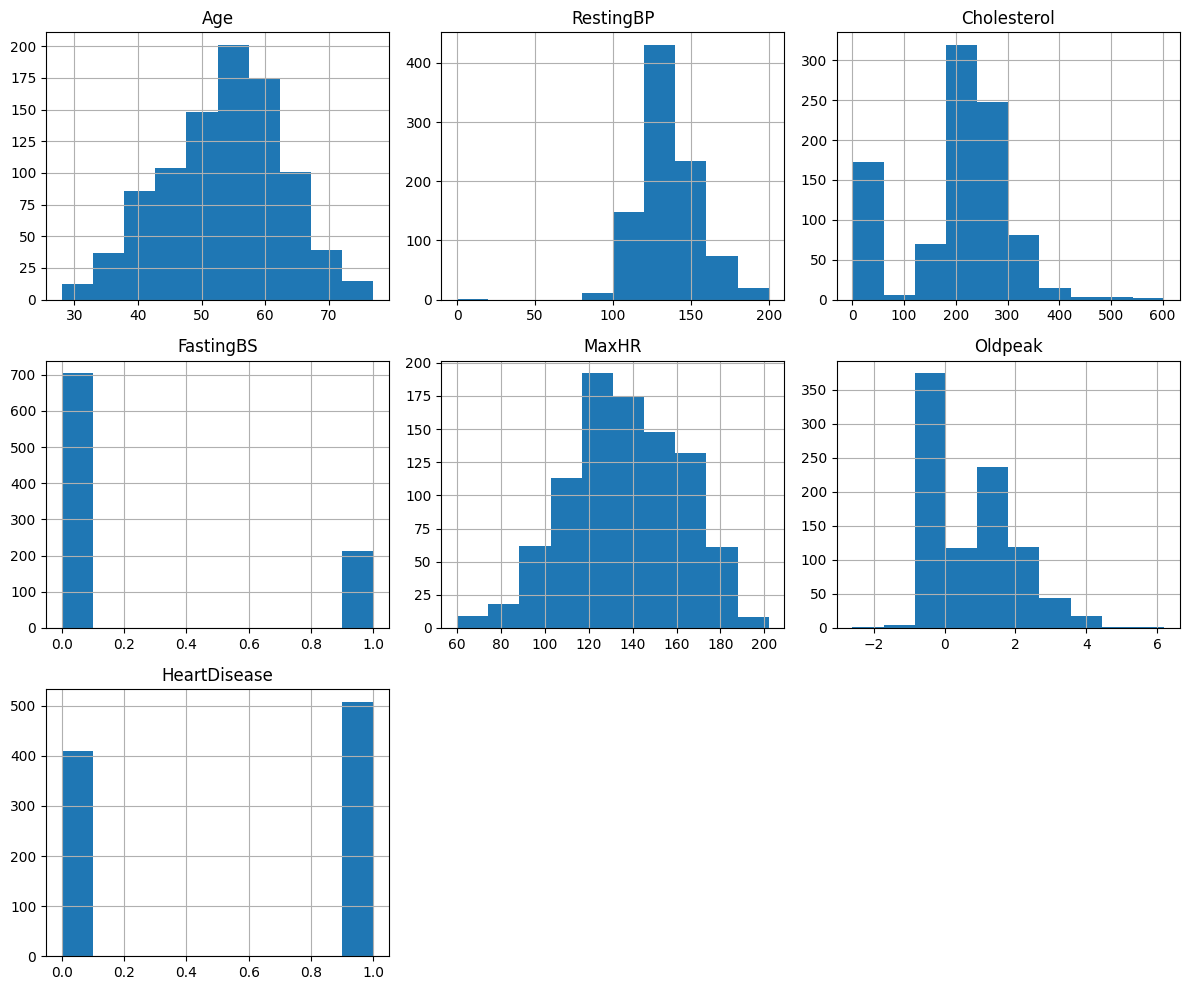

Variables sensibles potenciales: Sex, Age, ChestPainType


In [ ]:
# Tipos de datos
print(df.dtypes)

# Resumen estadístico
df.describe()

# Detección de valores únicos en cada columna
for col in df.columns:
    print(col, df[col].unique())

# Distribución de variables
df.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

# Posibles variables sensibles
print("Variables sensibles potenciales: Sex, Age, ChestPainType")

Construcción modelo predictivo

Accuracy: 0.8804347826086957
F1-Score: 0.8921568627450981

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87        82
           1       0.89      0.89      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



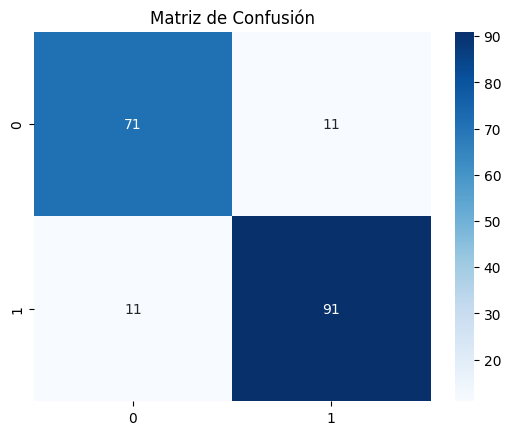

In [ ]:
# Variables predictoras y target
X = df.drop("HeartDisease", axis=1)
y = df["HeartDisease"]

# Variables categoricas
X = pd.get_dummies(X, drop_first=True)

# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Entrenamiento del modelo
model = RandomForestClassifier(random_state=42, n_estimators=200)
model.fit(X_train, y_train)

# Evaluación
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

# Matriz de confusión
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión")
plt.show()

Aplicación de SHAP

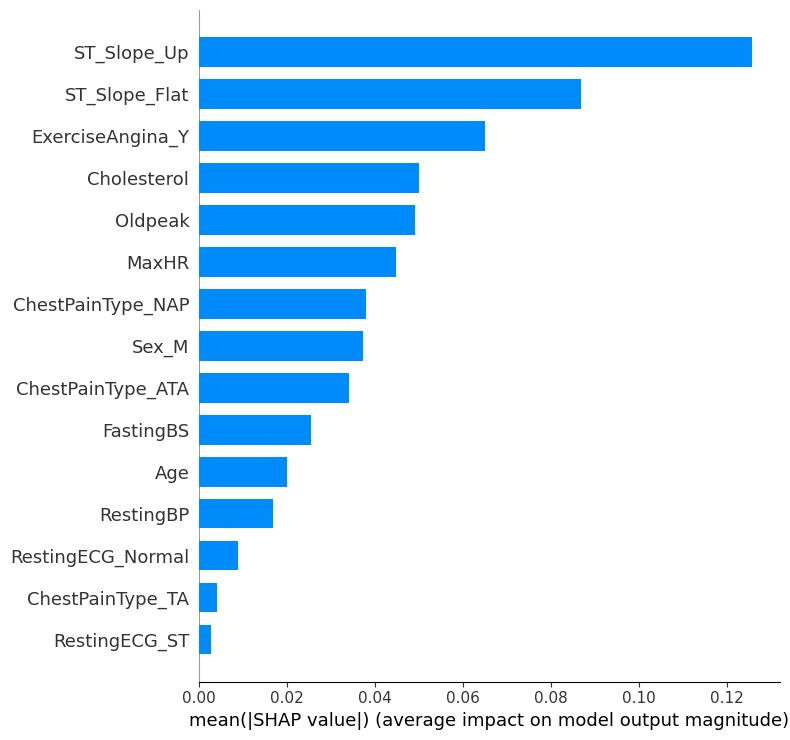

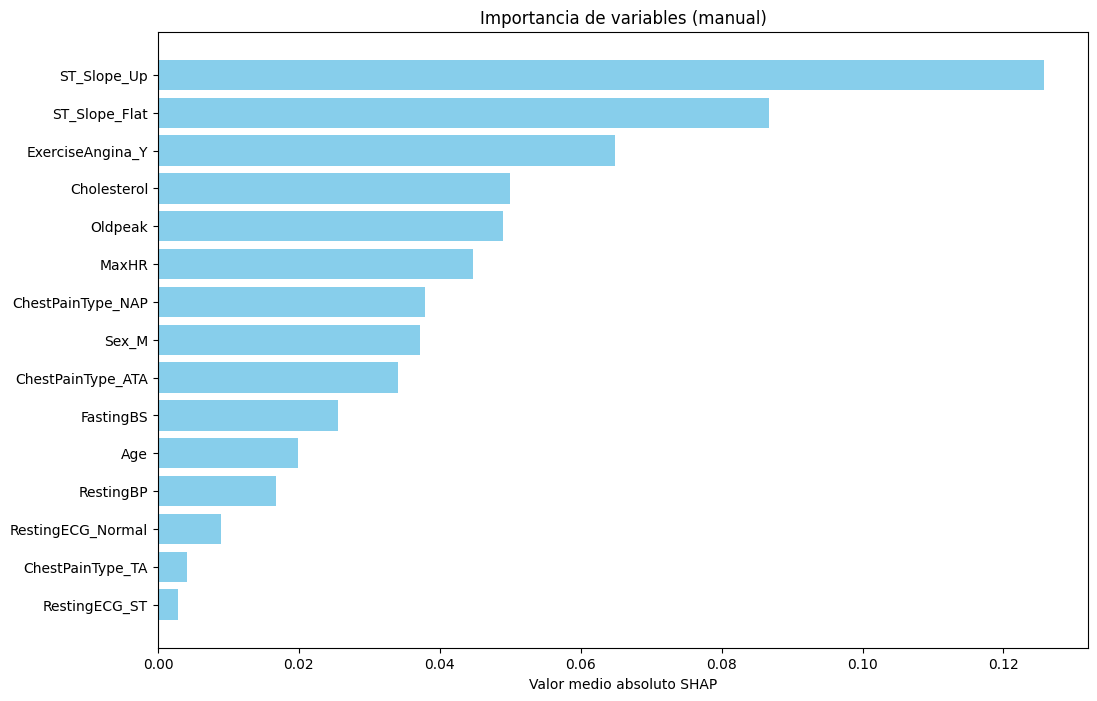

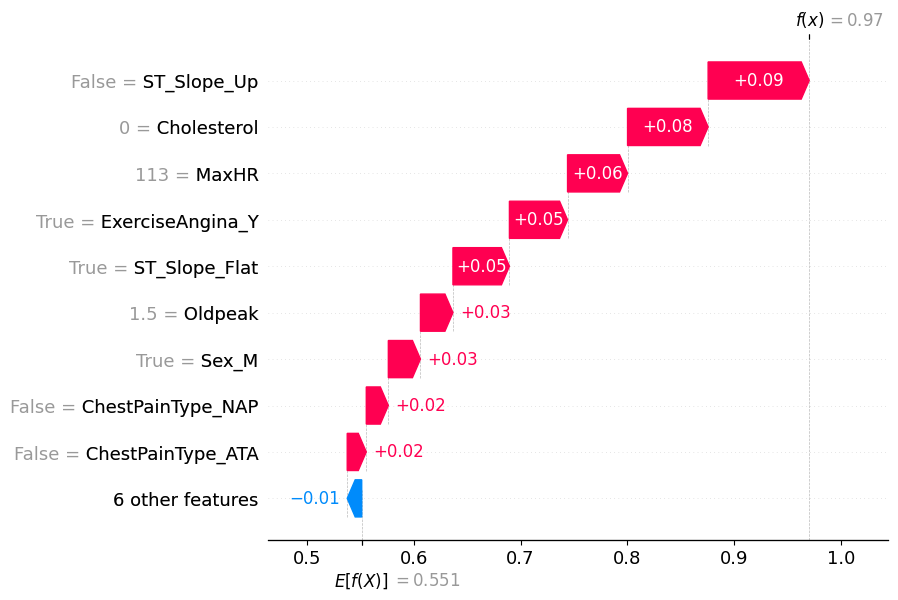

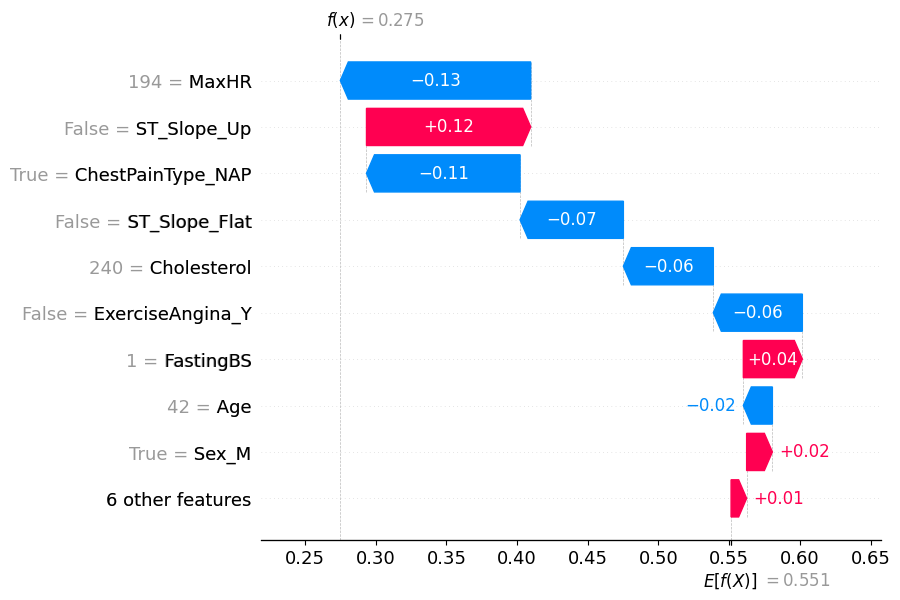

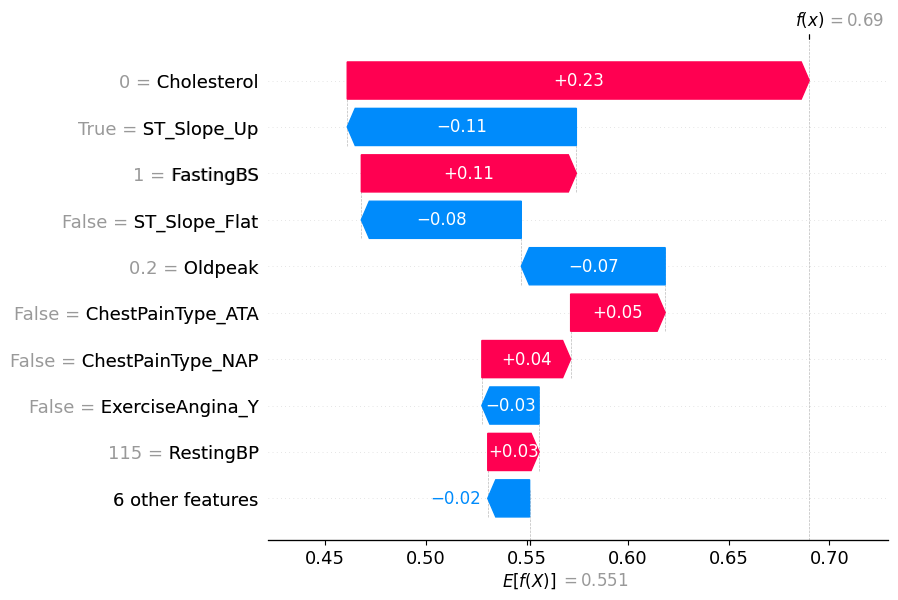

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,8)
from IPython.display import display, HTML

# Explicador
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.initjs()
for i, idx in enumerate([0, 5, 10]):
    display(HTML(f"<h4>Force plot caso {idx}</h4>"))
    display(shap.force_plot(
        explainer.expected_value[1],
        shap_values[1][idx],
        X_test.iloc[idx],
        matplotlib=False
    ))


# Summary plot tipo barra
shap.summary_plot(
    shap_values[1],
    X_test,
    feature_names=X_test.columns,
    plot_type="bar"
)

# Summary plot de puntos manual (evita colorbar bug), intente no hacerlo manual, pero aun con la version 0.41.0 me daba muchos problemas x.x
shap_df = pd.DataFrame(shap_values[1], columns=X_test.columns)
mean_abs_shap = shap_df.abs().mean().sort_values(ascending=True)

plt.barh(mean_abs_shap.index, mean_abs_shap.values, color="skyblue")
plt.xlabel("Valor medio absoluto SHAP")
plt.title("Importancia de variables (manual)")
plt.show()

# Waterfall plot, tuve que convertir los boleans a string para que funcionara
for idx in [0, 5, 10]:
    case_data = X_test.iloc[idx].copy().astype(str)
    display(HTML(f"<h4>Waterfall plot caso {idx}</h4>"))
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values[1][idx],
            base_values=explainer.expected_value[1],
            data=case_data,
            feature_names=X_test.columns
        )
    )

Explicación de LIME

In [ ]:
# Explicador LIME
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=["No Enfermedad", "Enfermedad"],
    mode="classification"
)

# Explicaciones locales (mismos casos que SHAP)
for i in [0, 5, 10]:
    exp = explainer_lime.explain_instance(
        X_test.iloc[i], model.predict_proba, num_features=8
    )
    exp.show_in_notebook(show_table=True)

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys 

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys 

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys 

En el caso 1 (probabilidad de enfermedad 97%) **ENFERMEDAD**: El paciente indica que tiene angina inducida por ejercicio y ST slope plano, factores que indican alto riesgo según el modelo realizado.

En el caso 2 (probabilidad de enfermedad 29%) **NO ENFERMEDAD**: En este caso, no hay angina inducida por ejercicio y ST slope no plano, al no tenerlos reducen el riesgo.

En el caso 3 (probablidad de enfermedad 69%) **ENFERMEDAD**: En el ultimo caso el modelo interpreta que un ST slope elevado junto con glucosa en ayunas alta aumenta la probalidad de enfermedad, aunque se presenten otros factores que disminuyen un poco el riesgo, a diferencia del primer caso.

PATRONES EMERGENTES:

**ST Slope**:
 -Plano o descendente: aumenta el riesgo.
 -Ascendente: disminuye el riesgo
**ExersiceAngina_Y**:
 -Presencia de angina inducida por ejercicio: aumenta el riesgo
 -Ausencia: reduce el riesgo
 **Tipo de dolor en el pecho(ChestPainType)**:
 NAP O ATA vs otros tipos tambien afecta la predicción del modelo.
